In [1]:
import os
import cv2
import torch
from torch.nn.functional import dropout
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import Adam
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassAccuracy
import copy

class SemanticSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir)])
        self.label_paths = sorted([os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir)])
        self.class_colors = {
            (2, 0, 0): 0,       
            (127, 0, 0): 1,     
            (248, 163, 191): 2  
        }
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = cv2.imread(self.label_paths[idx])
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

        label_mask = np.zeros(label.shape[:2], dtype=np.uint8)
        for rgb, idx in self.class_colors.items():
            label_mask[np.all(label == rgb, axis=-1)] = idx

        if self.transform:
            image = self.transform(image)
            label_mask = torch.from_numpy(label_mask).long()

        return image, label_mask

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

dataset = SemanticSegmentationDataset(
    image_dir='/mnt/data/trand/Desktop/Vuong/TT_AI/kaggle/input',
    label_dir='/mnt/data/trand/Desktop/Vuong/TT_AI/kaggle/label',
    transform=train_transform)

def evaluate(model, dataloader, criterion, device, num_classes):
    model.eval()
    running_loss = 0.0
    accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
    iou_metric = MulticlassJaccardIndex(num_classes=num_classes, average=None).to(device)  # average=None -> per-class IoU
    pbar = tqdm(dataloader, desc='Evaluating', unit='batch')

    with torch.no_grad():
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)

            accuracy_metric.update(preds, labels)
            iou_metric.update(preds, labels)

            per_class_iou = iou_metric.compute().detach().cpu().numpy()
            iou_str = ', '.join([f'{iou:.3f}' for iou in per_class_iou])
            pbar.set_postfix({
                'Batch Loss': f'{loss.item():.4f}',
                'Mean Accuracy': f'{accuracy_metric.compute():.4f}',
                'IoU per class': iou_str,
            })

    epoch_loss = running_loss / len(dataloader.dataset)
    mean_accuracy = accuracy_metric.compute().cpu().numpy()
    mean_iou = iou_metric.compute().cpu().numpy()

    return epoch_loss, mean_accuracy, mean_iou


total_size = len(dataset)
train_size = int(0.99 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = 3

criterion = nn.CrossEntropyLoss()


Train size: 5940, Validation size: 60


In [2]:
import matplotlib.pyplot as plt
import random

# Hàm chuyển mask (nhãn) thành ảnh RGB
def mask_to_rgb(mask, class_colors):
    """Chuyển nhãn (label mask) thành ảnh RGB dựa trên class_colors."""
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for rgb, idx in class_colors.items():
        rgb_mask[mask == idx] = rgb  # Gán màu theo class

    return rgb_mask

# Hàm lấy ngẫu nhiên một số mẫu từ bộ dữ liệu
def get_random_samples(dataloader, num_samples):
    """Lấy ngẫu nhiên một số ảnh từ bộ dữ liệu validation."""
    indices = random.sample(range(len(dataloader.dataset)), num_samples)  # Chọn ngẫu nhiên các chỉ số ảnh
    images_list, labels_list = [], []
    
    for idx in indices:
        image, label = dataloader.dataset[idx]  # Lấy ảnh và nhãn từ dataset theo chỉ số ngẫu nhiên
        images_list.append(image)
        labels_list.append(label)

    return torch.stack(images_list), torch.stack(labels_list)

# Hàm hiển thị ảnh, nhãn thực tế và nhãn dự đoán
def visualize_predictions(images, labels, preds, class_colors, num_samples=3):
    """Hiển thị ảnh đầu vào, nhãn thực tế và nhãn dự đoán."""
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))

    for j in range(num_samples):
        img = images[j].cpu().numpy().transpose(1, 2, 0)  # Chuyển Tensor về numpy
        lbl = labels[j].cpu().numpy()
        pred = preds[j].cpu().numpy()

        # Chuyển mask sang ảnh màu
        lbl_rgb = mask_to_rgb(lbl, class_colors)
        pred_rgb = mask_to_rgb(pred, class_colors)

        axes[j, 0].imshow(img)
        axes[j, 0].set_title("Input Image")
        axes[j, 0].axis("off")

        axes[j, 1].imshow(lbl_rgb)
        axes[j, 1].set_title("Ground Truth")
        axes[j, 1].axis("off")

        axes[j, 2].imshow(pred_rgb)
        axes[j, 2].set_title("Predicted Mask")
        axes[j, 2].axis("off")

    plt.show()

# Kiểm tra và hiển thị dự đoán
model = torch.jit.load("/mnt/data/trand/Desktop/Vuong/TT_AI/18.pt")
epoch_loss_val, mAcc_val, mIoU_val = evaluate(model, val_dataloader, criterion, device, classes)
print(f"Validation Loss: {epoch_loss_val:.4f}, Mean Accuracy: {mAcc_val:.4f}, Mean IoU: {mIoU_val.mean():.4f}")


Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s, Batch Loss=0.0085, Mean Accuracy=0.9962, IoU per class=0.992, 0.990, 0.995]

Validation Loss: 0.0081, Mean Accuracy: 0.9962, Mean IoU: 0.9923


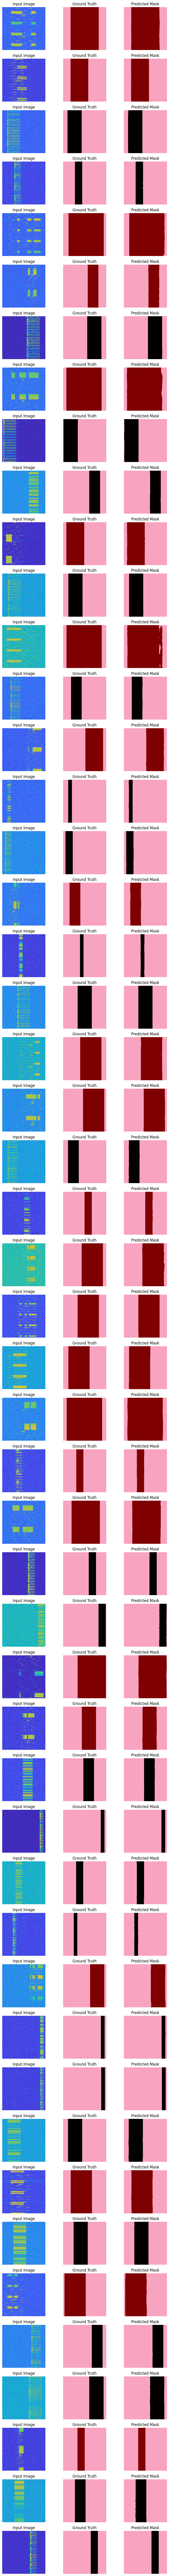

In [3]:
# Đánh giá mô hình
model.eval()
with torch.no_grad():
    images, labels = get_random_samples(val_dataloader, 50)
    images = images.to(device)
    labels = labels.to(device)

    # Dự đoán kết quả
    preds = model(images).argmax(dim=1)  # Lấy class có giá trị lớn nhất

    # Hiển thị kết quả
    visualize_predictions(images, labels, preds, dataset.class_colors, num_samples=50)

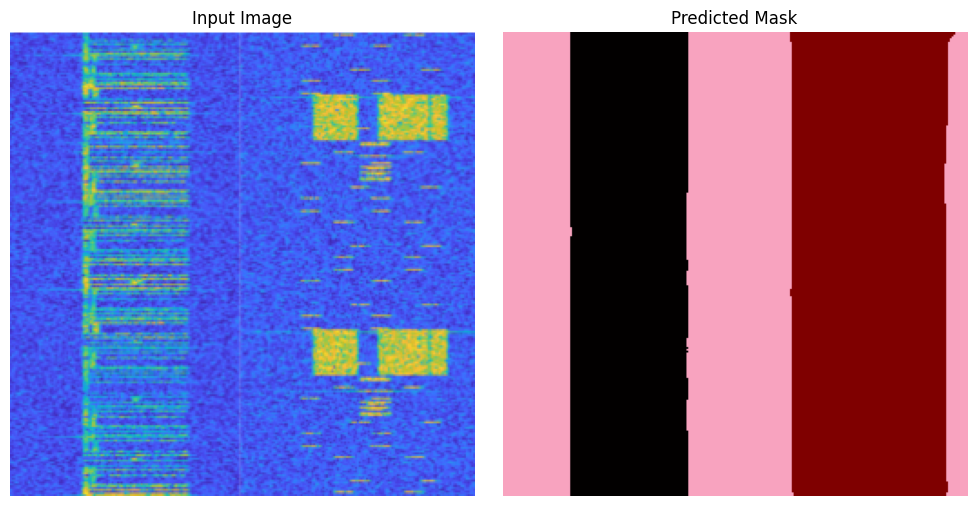

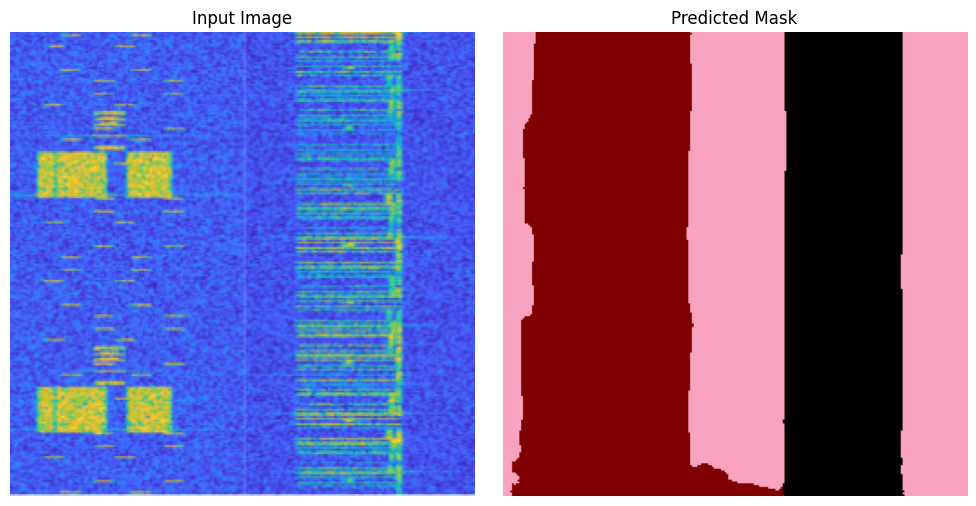

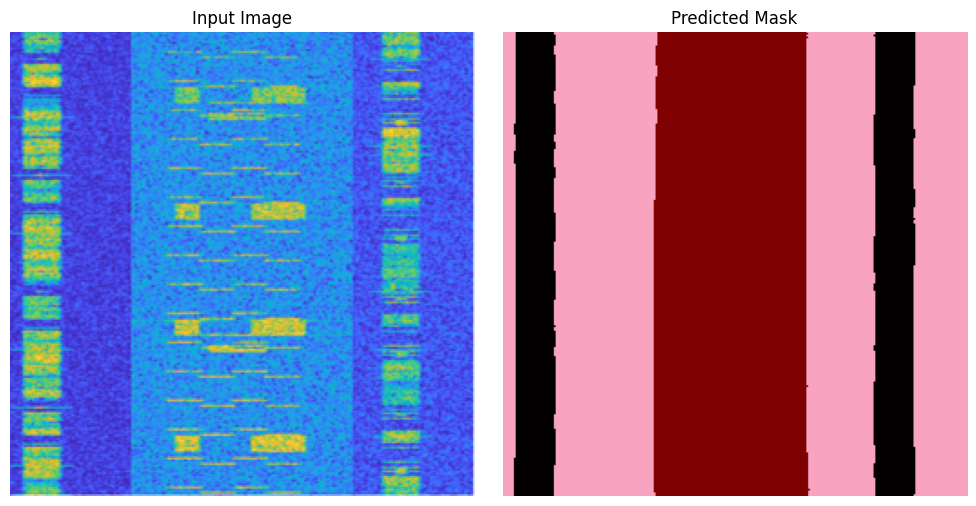

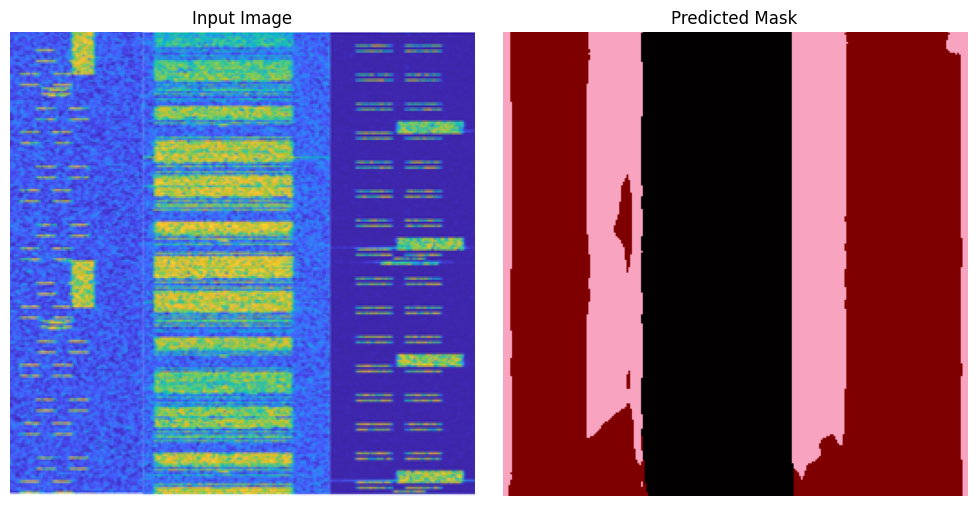

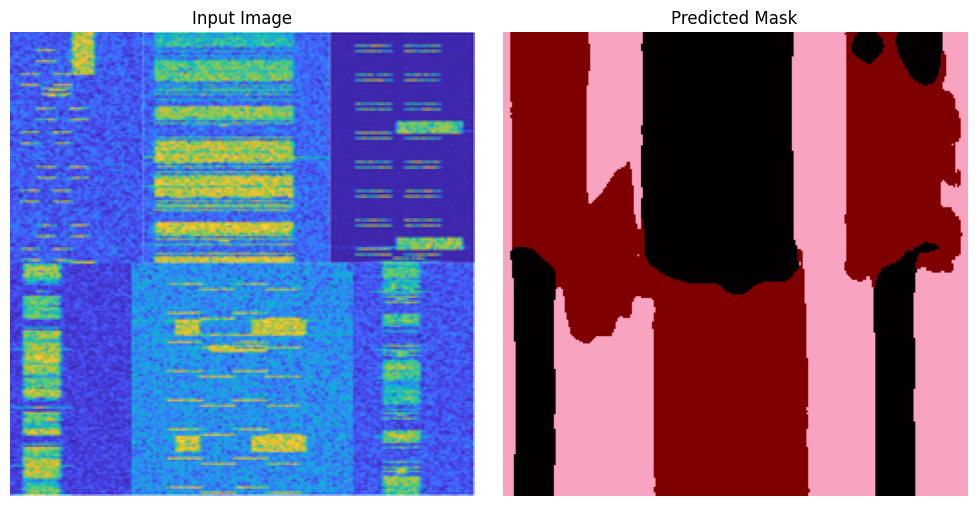

In [4]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# ----- 1. Load và tiền xử lý ảnh -----
def load_and_preprocess_image(image_path, device):
    image = Image.open(image_path).convert("RGB")

    transform = T.Compose([
        T.Resize((256, 256)),  # Resize đúng với input model
        T.ToTensor()
    ])

    input_tensor = transform(image).unsqueeze(0).to(device)  # [1, C, H, W]
    return image, input_tensor

# ----- 2. Dự đoán mask từ model -----
def predict_mask(model, input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)           # [1, C, H, W]
        pred_mask = output.argmax(dim=1)[0]    # [H, W]
    return pred_mask.cpu().numpy()

# ----- 3. Hiển thị kết quả -----
def visualize_prediction(image_pil, pred_mask_np, class_colors):
    pred_rgb = mask_to_rgb(pred_mask_np, class_colors)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_pil)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_rgb)
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# ----- 4. Thực thi -----
image_path = "test.png"  # Thay bằng ảnh thật
image_pil, input_tensor = load_and_preprocess_image(image_path, device)
pred_mask_np = predict_mask(model, input_tensor)
visualize_prediction(image_pil, pred_mask_np, dataset.class_colors)

image_path = "test1.png"  # Thay bằng ảnh thật
image_pil, input_tensor = load_and_preprocess_image(image_path, device)
pred_mask_np = predict_mask(model, input_tensor)
visualize_prediction(image_pil, pred_mask_np, dataset.class_colors)

image_path = "test2.png"  # Thay bằng ảnh thật
image_pil, input_tensor = load_and_preprocess_image(image_path, device)
pred_mask_np = predict_mask(model, input_tensor)
visualize_prediction(image_pil, pred_mask_np, dataset.class_colors)

image_path = "test3.png"  # Thay bằng ảnh thật
image_pil, input_tensor = load_and_preprocess_image(image_path, device)
pred_mask_np = predict_mask(model, input_tensor)
visualize_prediction(image_pil, pred_mask_np, dataset.class_colors)

image_path = "test4.png"  # Thay bằng ảnh thật
image_pil, input_tensor = load_and_preprocess_image(image_path, device)
pred_mask_np = predict_mask(model, input_tensor)
visualize_prediction(image_pil, pred_mask_np, dataset.class_colors)